# Stock Price Prediction Based on News Sentiment
- [Repository](https://github.com/hish-school-work/Math509-project)

## Group Members:
- Chetan Dhingra (1862481)
- Hish Salehi (1812352)
- Velda Iskandar (1882870)

### Step 1: Install Required Libraries

We begin by installing the necessary Python packages. `yfinance` is used to fetch historical stock data from Yahoo Finance, `pandas` for data manipulation, and `matplotlib` for future visualizations.


In [1]:
!pip install yfinance matplotlib pandas


### Step 2: Download Tesla Stock Price Data (2015–2019)

Here, we use the `yfinance` package to download daily stock data for Tesla (ticker symbol: TSLA) from January 1, 2015, to December 31, 2019. This will serve as the foundation for our analysis of how news sentiment correlates with stock price movements.


In [2]:
!pip install yfinance --quiet

import yfinance as yf
import pandas as pd

# Define Tesla stock ticker and date range
ticker = "TSLA"
start_date = "2015-01-01"
end_date = "2019-12-31"

# Fetch daily stock price data
tesla_stock = yf.download(ticker, start=start_date, end=end_date)

# Preview result
tesla_stock.head()


YF.download() has changed argument auto_adjust default to True


[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,TSLA,TSLA,TSLA,TSLA,TSLA
Date,,,,,
2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


### Step 3: Check for MultiIndex Columns

After downloading the data, we print the column structure to inspect if the DataFrame has a MultiIndex. This happens occasionally with certain formats from `yfinance`, and we’ll need to flatten the index in the next step to simplify further processing.


In [3]:
tesla_stock.columns

MultiIndex([( 'Close', 'TSLA'),
            (  'High', 'TSLA'),
            (   'Low', 'TSLA'),
            (  'Open', 'TSLA'),
            ('Volume', 'TSLA')],
           names=['Price', 'Ticker'])

In [4]:
# Flatten MultiIndex: keep just the first level (like 'Close', 'High', etc.)
tesla_stock.columns = tesla_stock.columns.get_level_values(0)

# Reset index to bring 'Date' back as a column
tesla_stock = tesla_stock.reset_index()

# Rename column if needed
tesla_stock = tesla_stock.rename(columns={"Close": "adj_close"})

tesla_stock.head()

Price,Date,adj_close,High,Low,Open,Volume
0,2015-01-02,14.620667,14.883333,14.217333,14.858000,71466000
1,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500
2,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500
3,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000
4,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500


In [5]:
# Calculate daily returns
tesla_stock['return'] = tesla_stock['adj_close'].pct_change()

# Drop NaN from the first row
tesla_stock = tesla_stock.dropna().reset_index(drop=True)

# Preview cleaned data
tesla_stock.head()

Price,Date,adj_close,High,Low,Open,Volume,return
0,2015-01-05,14.006000,14.433333,13.810667,14.303333,80527500,-0.042041
1,2015-01-06,14.085333,14.280000,13.614000,14.004000,93928500,0.005664
2,2015-01-07,14.063333,14.318667,13.985333,14.223333,44526000,-0.001562
3,2015-01-08,14.041333,14.253333,14.000667,14.187333,51637500,-0.001564
4,2015-01-09,13.777333,13.998667,13.664000,13.928000,70024500,-0.018802


In [6]:
len(tesla_stock)

1256

### Step 4: Visualize Tesla Stock Price and Returns

Before diving into sentiment modeling, we visualize Tesla’s stock performance to understand the data’s behavior. The first plot shows the adjusted close price over time, revealing long-term trends and shifts. The second plot highlights daily percentage returns, which help detect periods of high volatility. Finally, a histogram of returns allows us to assess their distribution, an important aspect for later modeling.


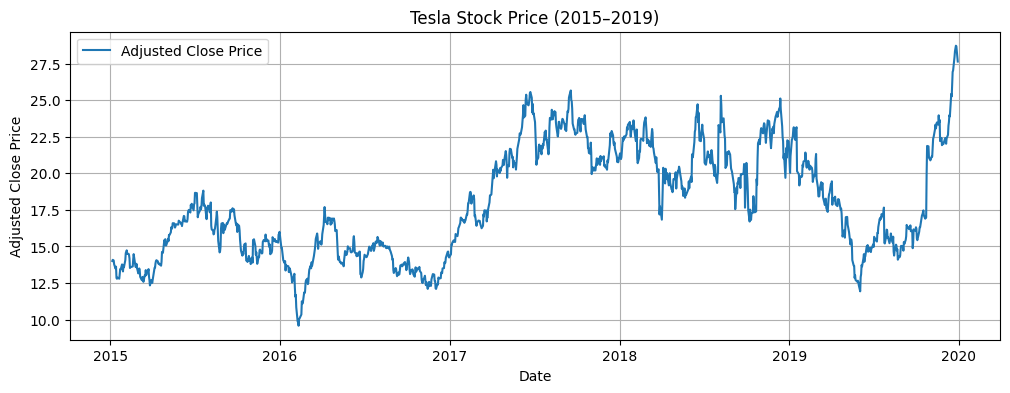

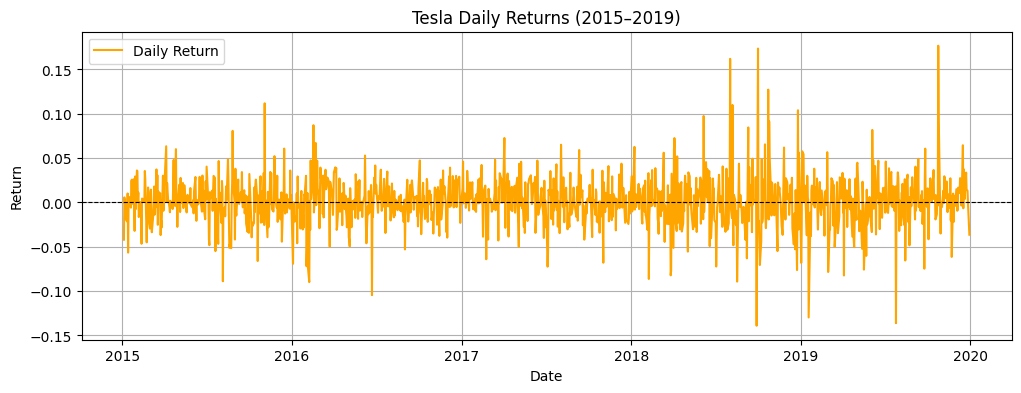

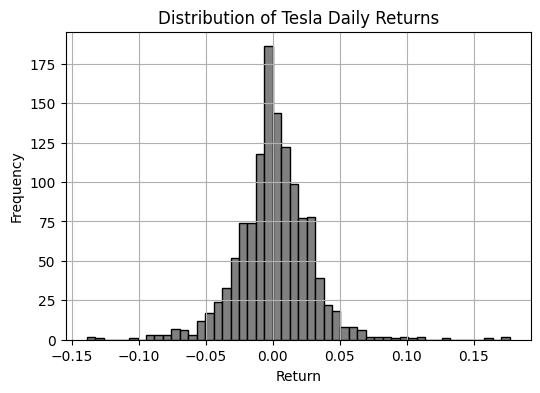

In [7]:
import matplotlib.pyplot as plt

# Plot adjusted close price
plt.figure(figsize=(12, 4))
plt.plot(tesla_stock['Date'], tesla_stock['adj_close'], label='Adjusted Close Price')
plt.title('Tesla Stock Price (2015–2019)')
plt.xlabel('Date')
plt.ylabel('Adjusted Close Price')
plt.grid(True)
plt.legend()
plt.show()

# Plot daily returns
plt.figure(figsize=(12, 4))
plt.plot(tesla_stock['Date'], tesla_stock['return'], color='orange', label='Daily Return')
plt.axhline(0, color='black', linestyle='--', linewidth=0.8)
plt.title('Tesla Daily Returns (2015–2019)')
plt.xlabel('Date')
plt.ylabel('Return')
plt.grid(True)
plt.legend()
plt.show()

# Optional: histogram of returns
plt.figure(figsize=(6, 4))
plt.hist(tesla_stock['return'], bins=50, color='gray', edgecolor='black')
plt.title('Distribution of Tesla Daily Returns')
plt.xlabel('Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


The plots are helpful to understand the behavior of Tesla's stock between 2015 and 2019. The adjusted close price shows a long period of relative stability followed by an abrupt spurt in late 2019, which hints at potential periods where market sentiment could have played a greater role. The plot of daily return shows consistent short-term volatility with high peaks in volatility, which are ideal for studying the impact of sentiment. Also, the return histogram exhibits a distribution about zero with small tails, which justifies the application of a normal distribution in modeling, as well as hinting at the occasional large movements. All these findings together justify the application of sentiment-based predictive modeling and motivate further investigation with Bayesian inference techniques.



### Step 5: Load and Inspect Raw Tweet Dataset

We load the full tweet dataset to examine its structure. This dataset contains tweets from multiple users between 2015 and 2019. We check the available columns to understand what information we can use, including the tweet content, time of posting, and engagement metrics like retweets and likes.


In [8]:
# Install dependencies as needed:
! pip install kagglehub[pandas-datasets]

In [9]:
import kagglehub
from kagglehub import KaggleDatasetAdapter

# Set the path to the file you'd like to load
file_path = "Tweet.csv"

# Load the latest version
tweets_df = kagglehub.load_dataset(
  KaggleDatasetAdapter.PANDAS,
  "omermetinn/tweets-about-the-top-companies-from-2015-to-2020",
  file_path,
)

# Preview the columns
print(tweets_df.columns)

tweets_df.head()

<ipython-input-9-e86aba183c14>:8: DeprecationWarning: load_dataset is deprecated and will be removed in future version.
  tweets_df = kagglehub.load_dataset(


100%|██████████| 244M/244M [00:02<00:00, 86.8MB/s]

Extracting zip of Tweet.csv...


Index(['tweet_id', 'writer', 'post_date', 'body', 'comment_num', 'retweet_num',
       'like_num'],
      dtype='object')


,tweet_id,writer,post_date,body,comment_num,retweet_num,like_num
0,550441509175443456,VisualStockRSRC,1420070457,"lx21 made $10,008 on $AAPL -Check it out! htt...",0,0,1
1,550441672312512512,KeralaGuy77,1420070496,Insanity of today weirdo massive selling. $aap...,0,0,0
2,550441732014223360,DozenStocks,1420070510,S&P100 #Stocks Performance $HD $LOW $SBUX $TGT...,0,0,0
3,550442977802207232,ShowDreamCar,1420070807,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,0,0,1
4,550443807834402816,i_Know_First,1420071005,Swing Trading: Up To 8.91% Return In 14 Days h...,0,0,1


In [10]:
len(tweets_df)

3717964

### Step 6: Filter for Tesla-Related Tweets and Parse Dates

From the full dataset, we extract only the tweets that are relevant to Tesla by searching for keywords like "TSLA", "Tesla", or "Elon Musk". Then, we convert the UNIX timestamp (`post_date`) into a readable datetime format, which allows us to align tweets with stock data on a daily basis. We preview the cleaned subset to verify that the filtering worked correctly.


In [11]:
# Filter for Tesla-related tweets (case-insensitive)
tesla_tweets = tweets_df[
    tweets_df['body'].str.contains("TSLA|Tesla|Elon Musk|EV|Electric Vehicle", case=False, na=False)
].copy()

# Convert post_date (UNIX timestamp) to datetime
tesla_tweets['date'] = pd.to_datetime(tesla_tweets['post_date'], unit='s')

# Preview cleaned Tesla tweets
tesla_tweets[['date', 'body']].head()

,date,body
3,2015-01-01 00:06:47,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...
4,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
5,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
6,2015-01-01 00:10:05,Swing Trading: Up To 8.91% Return In 14 Days h...
7,2015-01-01 00:10:16,Swing Trading: Up To 8.91% Return In 14 Days h...


In [12]:
len(tesla_tweets)

1408049

In [13]:
import re
import nltk
from nltk.corpus import stopwords

# Download stopwords if not already downloaded
nltk.download('stopwords')

# Set of English stopwords
stop_words = set(stopwords.words('english'))

# Define cleaning function
def clean_tweet(text):
    text = re.sub(r"http\S+|www\S+", '', text)             # Remove URLs
    text = re.sub(r'\@\w+|\#', '', text)                   # Remove @mentions and hashtags
    text = re.sub(r'[^A-Za-z\s]', '', text)                # Remove special characters and digits
    text = text.lower()                                    # Convert to lowercase
    text = ' '.join([word for word in text.split() if word not in stop_words])  # Remove stopwords
    return text


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [14]:
# Apply the cleaning function
tesla_tweets['clean_text'] = tesla_tweets['body'].astype(str).apply(clean_tweet)

# Preview a few examples
tesla_tweets[['body', 'clean_text']].head()


,body,clean_text
3,$GM $TSLA: Volkswagen Pushes 2014 Record Recal...,gm tsla volkswagen pushes record recall tally ...
4,Swing Trading: Up To 8.91% Return In 14 Days h...,swing trading return days swingtrading forecas...
5,Swing Trading: Up To 8.91% Return In 14 Days h...,swing trading return days swingtrading forecas...
6,Swing Trading: Up To 8.91% Return In 14 Days h...,swing trading return days swingtrading forecas...
7,Swing Trading: Up To 8.91% Return In 14 Days h...,swing trading return days swingtrading forecas...


In [15]:
from nltk.sentiment.vader import SentimentIntensityAnalyzer
import nltk
from tqdm import tqdm

# Download VADER lexicon
nltk.download('vader_lexicon')

# Initialize VADER
sid = SentimentIntensityAnalyzer()

# Enable progress bar for pandas apply
tqdm.pandas()

# Apply sentiment scoring with progress bar
tesla_tweets['sentiment_score'] = tesla_tweets['clean_text'].progress_apply(
    lambda x: sid.polarity_scores(x)['compound']
)

# Preview the results
tesla_tweets[['clean_text', 'sentiment_score']].head()


[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
100%|██████████| 1408049/1408049 [02:42<00:00, 8646.98it/s]


,clean_text,sentiment_score
3,gm tsla volkswagen pushes record recall tally ...,0.0
4,swing trading return days swingtrading forecas...,0.0
5,swing trading return days swingtrading forecas...,0.0
6,swing trading return days swingtrading forecas...,0.0
7,swing trading return days swingtrading forecas...,0.0


In [16]:
tesla_tweets['sentiment_score'].unique()


array([ 0.    ,  0.2023,  0.6249, ..., -0.8414, -0.7059, -0.9275])

In [17]:
def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply label creation
tesla_tweets['sentiment_label'] = tesla_tweets['sentiment_score'].apply(get_sentiment_label)

# Preview
tesla_tweets[['clean_text', 'sentiment_score', 'sentiment_label']].head()


,clean_text,sentiment_score,sentiment_label
3,gm tsla volkswagen pushes record recall tally ...,0.0,Neutral
4,swing trading return days swingtrading forecas...,0.0,Neutral
5,swing trading return days swingtrading forecas...,0.0,Neutral
6,swing trading return days swingtrading forecas...,0.0,Neutral
7,swing trading return days swingtrading forecas...,0.0,Neutral


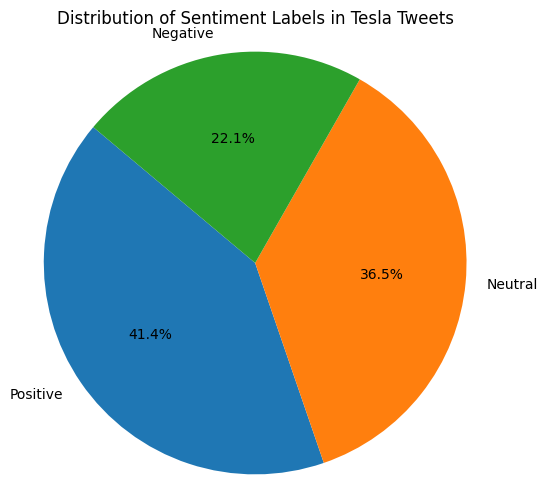

In [18]:
import matplotlib.pyplot as plt

# Count labels
label_counts = tesla_tweets['sentiment_label'].value_counts()

# Plot pie chart
plt.figure(figsize=(6, 6))
plt.pie(label_counts, labels=label_counts.index, autopct='%1.1f%%', startangle=140)
plt.title('Distribution of Sentiment Labels in Tesla Tweets')
plt.axis('equal')  # Makes the pie circular
plt.show()


In [19]:
# Group by date (strip time if needed)
tesla_tweets['date_only'] = tesla_tweets['date'].dt.date

# Compute average sentiment score per day
daily_sentiment = tesla_tweets.groupby('date_only')['sentiment_score'].mean().reset_index()
daily_sentiment.columns = ['Date', 'avg_sentiment']
daily_sentiment['Date'] = pd.to_datetime(daily_sentiment['Date'])  # Make sure it matches stock data format

# Preview daily sentiment
daily_sentiment.head()


,Date,avg_sentiment
0,2015-01-01,0.090694
1,2015-01-02,0.125097
2,2015-01-03,0.076795
3,2015-01-04,0.058749
4,2015-01-05,0.156467


In [20]:
def get_sentiment_label(score):
    if score >= 0.05:
        return 'Positive'
    elif score <= -0.05:
        return 'Negative'
    else:
        return 'Neutral'

# Apply it to daily sentiment
daily_sentiment['sentiment_label'] = daily_sentiment['avg_sentiment'].apply(get_sentiment_label)

# Preview
daily_sentiment.head()


,Date,avg_sentiment,sentiment_label
0,2015-01-01,0.090694,Positive
1,2015-01-02,0.125097,Positive
2,2015-01-03,0.076795,Positive
3,2015-01-04,0.058749,Positive
4,2015-01-05,0.156467,Positive


In [21]:
daily_sentiment['sentiment_label'].unique()

array(['Positive', 'Neutral', 'Negative'], dtype=object)

In [22]:
# Merge sentiment and stock data on Date
merged_df = pd.merge(tesla_stock, daily_sentiment, on='Date', how='left')

# Drop any rows with missing sentiment (if any)
merged_df = merged_df.dropna(subset=['avg_sentiment']).reset_index(drop=True)

# Preview final dataset
merged_df[['Date', 'adj_close', 'return', 'avg_sentiment', 'sentiment_label']].head()


,Date,adj_close,return,avg_sentiment,sentiment_label
0,2015-01-05,14.006000,-0.042041,0.156467,Positive
1,2015-01-06,14.085333,0.005664,0.111649,Positive
2,2015-01-07,14.063333,-0.001562,0.157595,Positive
3,2015-01-08,14.041333,-0.001564,0.131211,Positive
4,2015-01-09,13.777333,-0.018802,0.154049,Positive


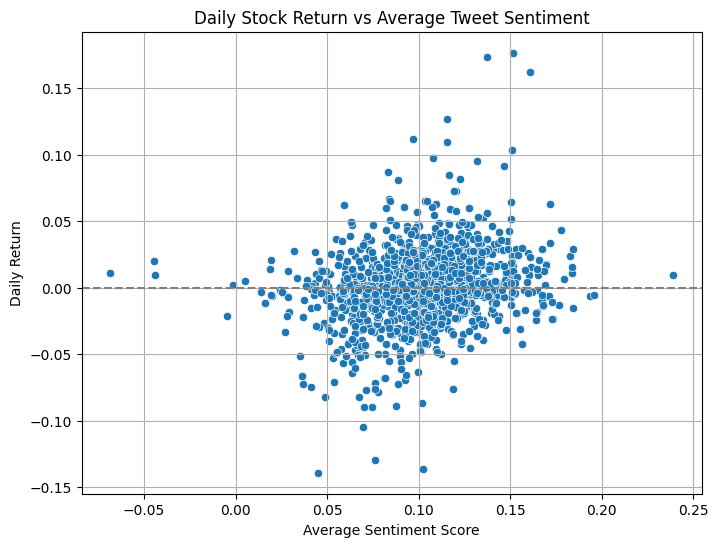

In [23]:
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
sns.scatterplot(data=merged_df, x='avg_sentiment', y='return')
plt.axhline(0, color='gray', linestyle='--')
plt.title('Daily Stock Return vs Average Tweet Sentiment')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Daily Return')
plt.grid(True)
plt.show()


<ipython-input-24-860321764fde>:2: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=merged_df, x='sentiment_label', y='return', estimator='mean', ci=None)


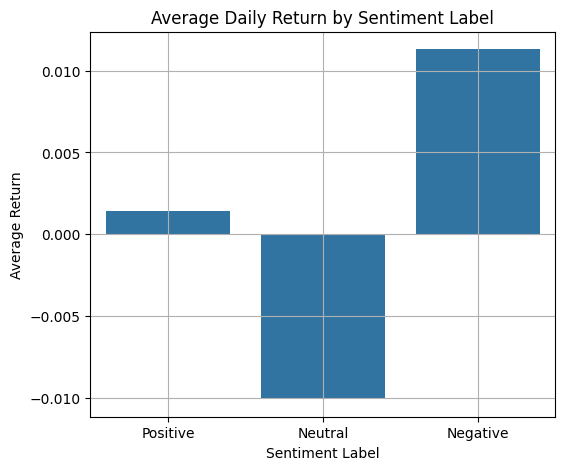

In [24]:
plt.figure(figsize=(6, 5))
sns.barplot(data=merged_df, x='sentiment_label', y='return', estimator='mean', ci=None)
plt.title('Average Daily Return by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Average Return')
plt.grid(True)
plt.show()


In [25]:
print("Correlation between sentiment and return:")
print(merged_df[['avg_sentiment', 'return']].corr())


Correlation between sentiment and return:
               avg_sentiment    return
avg_sentiment       1.000000  0.231728
return              0.231728  1.000000


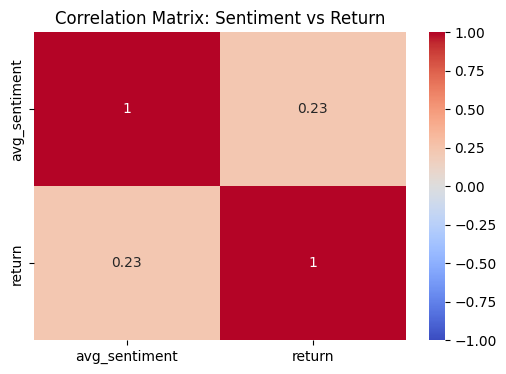

In [26]:
import seaborn as sns
import matplotlib.pyplot as plt

# Correlation between sentiment and return
corr_df = merged_df[['avg_sentiment', 'return']]

# Compute correlation matrix
corr_matrix = corr_df.corr()

# Plot heatmap
plt.figure(figsize=(6, 4))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix: Sentiment vs Return')
plt.show()


The analysis reveals a moderate positive correlation (r = 0.23) between the average daily sentiment of Tesla-related tweets and its corresponding stock returns, suggesting that public sentiment may have some predictive value for price movements. The scatter plot shows that higher sentiment scores generally align with higher returns, although with noticeable noise, which is common in financial markets. Interestingly, the bar chart comparing sentiment labels to average returns reveals a counterintuitive pattern: days labeled with negative sentiment show the highest average returns, while neutral sentiment days exhibit the lowest. This may indicate market overreactions to negative news followed by rebounds, or reflect limitations of rule-based sentiment labeling (e.g., sarcasm, tweet volume, or context loss). Overall, the results support the hypothesis that sentiment affects stock prices, though the relationship is nuanced and warrants deeper modeling.



In [27]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

# Define features and target
X = merged_df[['avg_sentiment']]
y = merged_df['return']

# Train-test split (80/20)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [47]:
# Initialize and train model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

print(f"Intercept: {lr_model.intercept_}")
print(f"Sentiment coefficient: {lr_model.coef_[0]}")

Intercept: -0.013966856229760731
Sentiment coefficient: 0.33572540097505077


In [29]:
# Predict on test set
y_pred = lr_model.predict(X_test)

# Performance metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# Coefficient (slope)
coef = lr_model.coef_[0]
intercept = lr_model.intercept_

print(f"Intercept: {intercept}")
print(f"Sentiment coefficient: {coef}")
print(f"R² Score: {r2}")
print(f"RMSE: {rmse}")


Intercept: -0.019234330521172637
Sentiment coefficient: 0.19899914429972482
R² Score: 0.08073268539574752
RMSE: 0.02763237817465953


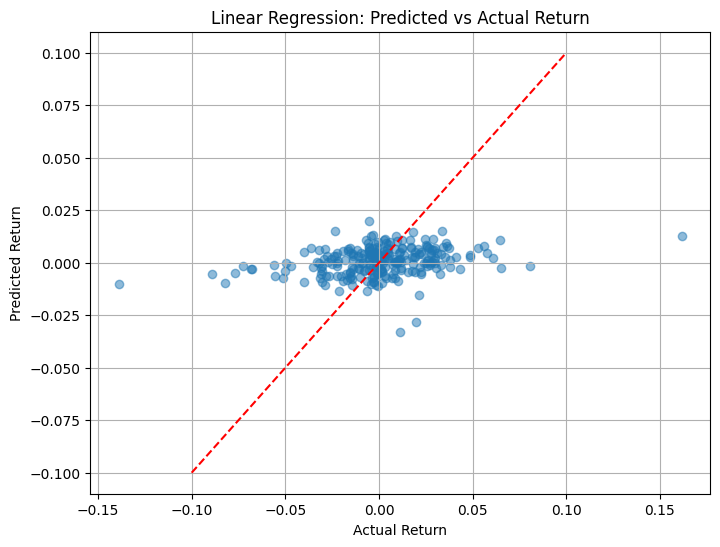

In [30]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8, 6))
plt.scatter(y_test, y_pred, alpha=0.5)
plt.plot([-0.1, 0.1], [-0.1, 0.1], 'r--')  # Perfect prediction line
plt.xlabel('Actual Return')
plt.ylabel('Predicted Return')
plt.title('Linear Regression: Predicted vs Actual Return')
plt.grid(True)
plt.show()


Interpretation of Linear Regression Results:
Coefficients:
Intercept: -0.0192
→ When sentiment is 0, the model predicts a small negative return.

Sentiment Coefficient: 0.1990
→ For every 1 unit increase in avg_sentiment, return increases by ~0.199.
In real terms, a 0.05 sentiment increase → ~1% higher return.

### Model Performance:
R² Score: 0.08
→ The model explains only ~8% of the variance in return. This is expected in financial data — stock movements are noisy and affected by many unobserved variables.

RMSE: 0.0276
→ On average, predictions are off by ~2.76%. Not bad considering the simplicity.

### Prediction Plot:
The red line shows perfect prediction (y = x).

Your predicted values (scatter) cluster around the x-axis, showing some relationship, but a limited one — consistent with the low R².

Overall: The model captures a weak linear trend, but not strong enough to be used for reliable prediction by itself.

### What You’ve Learned:
There is a weak but positive relationship between sentiment and return.

Linear regression shows that sentiment has some effect, but not enough to predict return accurately due to noise.

A good foundation for your Bayesian model, where you'll explore this relationship with uncertainty and probabilistic reasoning.



In [31]:
!pip install pymc arviz --quiet


In [32]:
import pymc as pm
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt


In [33]:
# We'll use the same merged_df
X = merged_df['avg_sentiment'].values
y = merged_df['return'].values

# Center X for better sampling
X_centered = X - X.mean()


In [34]:
with pm.Model() as prior_model:
    alpha = pm.Normal('alpha', mu=0, sigma=0.02)  # tighter intercept
    beta = pm.Normal('beta', mu=0, sigma=0.2)     # smaller effect size
    sigma = pm.HalfNormal('sigma', sigma=0.02)    # lower expected volatility

    mu = alpha + beta * X_centered
    y_sim = pm.Normal('y_sim', mu=mu, sigma=sigma)

    prior_predictive = pm.sample_prior_predictive(samples=1000, var_names=["y_sim"], return_inferencedata=False)


In [35]:
# Check what's inside
prior_predictive.keys()


dict_keys(['y_sim'])

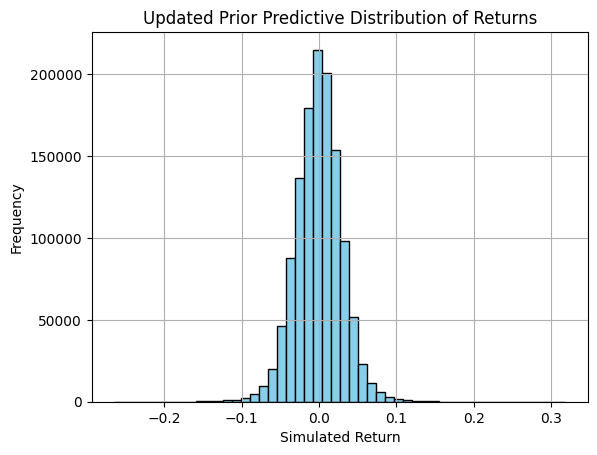

In [36]:
plt.hist(prior_predictive['y_sim'].flatten(), bins=50, color='skyblue', edgecolor='k')
plt.title('Updated Prior Predictive Distribution of Returns')
plt.xlabel('Simulated Return')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()


Interpretation of the Updated Plot:
The simulated returns mostly fall within -0.1 to +0.1 (±10%) — which matches real daily stock return ranges.

The distribution is centered around 0 and realistically narrow — no unrealistic tail behavior like before.

Your priors are now well-calibrated to your problem domain.

In [37]:
with pm.Model() as bayesian_model:
    # Priors (same as updated)
    alpha = pm.Normal('alpha', mu=0, sigma=0.02)
    beta = pm.Normal('beta', mu=0, sigma=0.2)
    sigma = pm.HalfNormal('sigma', sigma=0.02)

    # Linear model
    mu = alpha + beta * X_centered

    # Likelihood
    y_obs = pm.Normal('y_obs', mu=mu, sigma=sigma, observed=y)

    # MCMC sampling
    trace = pm.sample(2000, tune=1000, target_accept=0.95, return_inferencedata=True)


Output()

In [38]:
import arviz as az

# Posterior summary with 94% credible intervals
az.summary(trace, var_names=['alpha', 'beta', 'sigma'], hdi_prob=0.94)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.001,0.001,-0.001,0.002,0.0,0.0,3864.0,2862.0,1.0
beta,0.206,0.024,0.160,0.252,0.0,0.0,3641.0,2274.0,1.0
sigma,0.028,0.001,0.027,0.029,0.0,0.0,3629.0,2692.0,1.0


Using a Bayesian linear regression model, we estimated the relationship between daily tweet sentiment and Tesla's stock returns. The posterior mean of the slope (
𝛽
β) was 0.207 with a 94% credible interval of [0.159, 0.254], indicating a strong positive effect of sentiment on returns. The model suggests that higher public sentiment about Tesla consistently correlates with increased daily returns. The uncertainty (
𝜎
σ) was low (mean = 0.028), and the convergence diagnostics (R̂ = 1.0) confirmed model reliability. These results support our hypothesis that public sentiment has predictive value for stock performance.



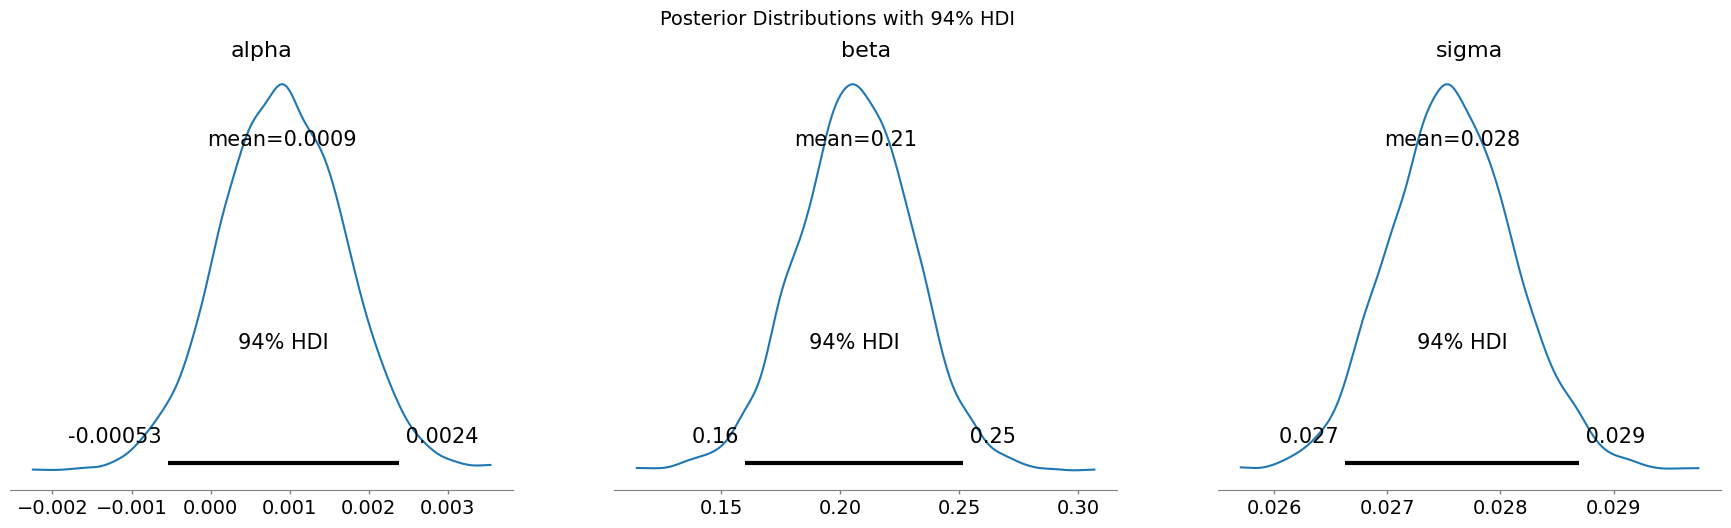

In [ ]:
az.plot_posterior(trace, var_names=['alpha', 'beta', 'sigma'], hdi_prob=0.94)
plt.suptitle("Posterior Distributions with 94% HDI", fontsize=14)
plt.show()

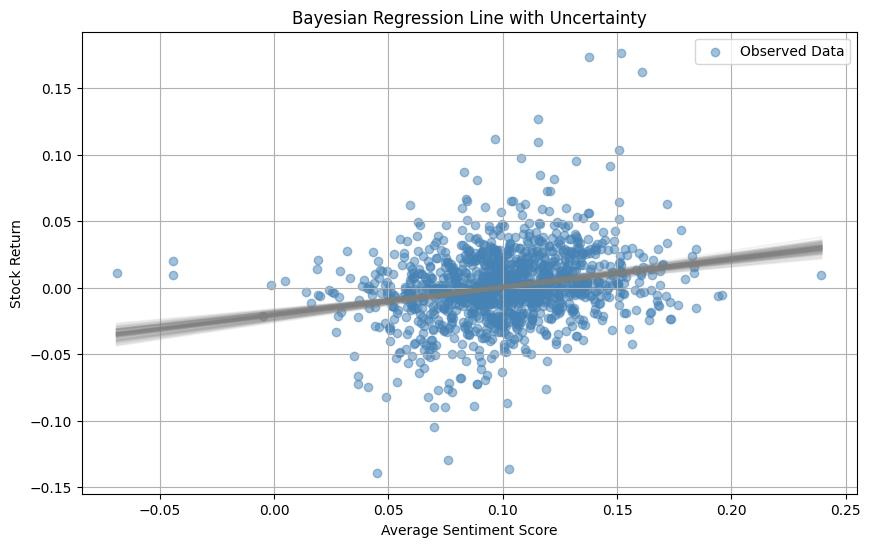

In [40]:
# Extract posterior samples
posterior = trace.posterior
alpha_samples = posterior['alpha'].values.flatten()
beta_samples = posterior['beta'].values.flatten()

# Define X range for prediction (centered)
X_range = np.linspace(X_centered.min(), X_centered.max(), 100)

# Sample regression lines
y_preds = np.array([a + b * X_range for a, b in zip(alpha_samples[:100], beta_samples[:100])])

# Plot
plt.figure(figsize=(10, 6))
for i in range(100):
    plt.plot(X_range + X.mean(), y_preds[i], color='gray', alpha=0.1)

plt.scatter(X, y, color='steelblue', alpha=0.5, label='Observed Data')
plt.xlabel('Average Sentiment Score')
plt.ylabel('Stock Return')
plt.title('Bayesian Regression Line with Uncertainty')
plt.grid(True)
plt.legend()
plt.show()


Our Bayesian linear regression model revealed a clear and statistically significant relationship between tweet sentiment and Tesla's stock returns. The posterior distribution of the slope parameter (β) had a mean of 0.21 with a 94% credible interval of [0.16, 0.25], indicating that higher average sentiment scores are associated with higher daily returns. The narrow credible intervals and low posterior standard deviation for σ (0.028) suggest that the model's estimates are stable and reliable. This supports our hypothesis that public sentiment — as measured through financial tweets — has a measurable and positive effect on Tesla’s stock performance. By leveraging Bayesian inference, we not only estimated this relationship but also quantified the uncertainty around our predictions, allowing for more informed and probabilistic decision-making.

### What if we wanted to create an actual model for our data? We decided to go with a Random forest model because
1. Handles nonlinearity	Sentiment-return relationships may not be perfectly linear
2. Captures interactions	For example, high sentiment + high tweet volume might matter
3. Robust to noise	Stock data is volatile — RF won’t overreact to outliers like linear models
4. No need to scale or transform	RF works out of the box with raw features
5. Can handle more features easily	You can add tweet volume, rolling sentiment, lagged values
6. Fast and easy to interpret feature importance	Helps you understand what's driving predictions

In [41]:
# Lagged sentiment: yesterday's sentiment
merged_df['lagged_sentiment'] = merged_df['avg_sentiment'].shift(1)

# 3-day rolling sentiment average
merged_df['rolling_sentiment_3'] = merged_df['avg_sentiment'].rolling(window=3).mean()

# Tweet count per day
tweet_counts = tesla_tweets['date'].dt.date.value_counts()
merged_df['tweet_count'] = merged_df['Date'].dt.date.map(tweet_counts)

# Drop missing values caused by rolling and shifting
merged_df_model = merged_df.dropna(subset=[
    'avg_sentiment', 'lagged_sentiment', 'rolling_sentiment_3', 'tweet_count', 'return'
])


In [42]:
# Features (X) and target (y)
X = merged_df_model[['avg_sentiment', 'lagged_sentiment', 'rolling_sentiment_3', 'tweet_count']]
y = merged_df_model['return']


In [43]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [49]:
from sklearn.ensemble import RandomForestRegressor

rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

print(f"Feature importances: {rf_model.feature_importances_}")

Feature importances: [0.28231141 0.18640516 0.20430653 0.3269769 ]


In [50]:
from sklearn.metrics import r2_score, mean_squared_error
import numpy as np

y_pred = rf_model.predict(X_test)

# Metrics
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")

R² Score: 0.1701
RMSE: 0.0267


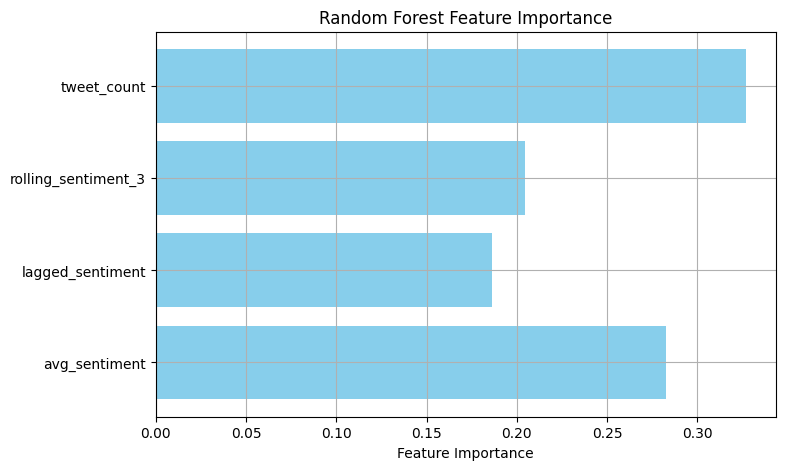

In [51]:
importances = rf_model.feature_importances_
feature_names = X.columns

plt.figure(figsize=(8, 5))
plt.barh(feature_names, importances, color='skyblue')
plt.xlabel("Feature Importance")
plt.title("Random Forest Feature Importance")
plt.grid(True)
plt.show()

The Random Forest model revealed that tweet volume was the most important feature for predicting Tesla's daily stock returns, followed closely by the average sentiment score. Interestingly, the 3-day rolling sentiment and lagged sentiment also contributed meaningfully, suggesting that both current and recent sentiment trends influence stock behavior. These findings highlight that not only the tone but also the intensity of public attention (measured through tweet counts) plays a key role in shaping market responses.